In [2]:
import pandas as pd
import numpy as np
from time import process_time
from joblib import dump
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from gensim.models.ldamodel import LdaModel
from data_preprocessing import *
from model import *

import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Embedding, Input, Dense, LSTM, Dropout, Flatten, Bidirectional, Conv1D, concatenate, SpatialDropout1D
from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalAveragePooling2D, GlobalAveragePooling1D 

print(tf.__version__)

2.2.0


In [3]:
training_path = "../dataset/original-dataset/marathi-training-data.csv"
training_data = read_data(training_path)
training_data

,text,label
0,"प्रा . प्रताप हरिदास : होय , मला वाटते की हा ए...",com_tech
1,"तर , विशिष्ट गोष्टींद्वारे , ठराविक कायद्यांद्...",bioche
2,- - - - - - - - - - - - - - - - - - - - - - - ...,cse
3,"तर , आपला अर्धा चिन्ह 9 वाजता असेल .",phy
4,"म्हणून , मी असे म्हणालो की जर शेकडो , हजारो कि...",phy
...,...,...
41992,"जरी आपण डेटा कूटबद्ध केला , तरीही हा मुख्य व्य...",cse
41993,"ते म्हणतात - "" ज्याला पाहण्यासाठी डोळे , ऎकण्य...",com_tech
41994,"प्रथम क्रोनोलॉजिकल , क्रॉनोलॉजी म्हणजे आपल्याल...",com_tech
41995,"त्या थोड्या तपशीलावर येईल , जेणेकरून संपूर्ण ग...",bioche


In [4]:
val_path = "../dataset/original-dataset/marathi-validation-data.csv"
val_data = read_data(val_path)
val_data

,text,label
0,1 ची ओळ .,cse
1,"तर , ही एक टॉवर आहे जी टॉवरवर निश्चित केली जात...",phy
2,"तर , थ्रेडच्या परतीच्या स्थितीस पास करण्यासाठी...",cse
3,आपण लोक शोधत आहात जे आपल्यासाठी काहीतरी करू शक...,com_tech
4,लिनक्स कर्नल अनुसूचीतकरणामध्ये अशी तंत्र असण्य...,cse
...,...,...
3775,"नंतर वृद्धत्व , व्हॉट मोठ्या प्रमाणात फ्रॉन 12...",bioche
3776,आणि मग सुद्धा आपल्याला काही सेकंदांनंतर माहित ...,phy
3777,"तर , आपण ELF शीर्षलेखासह प्रारंभ करू .",cse
3778,"तर , त्या क्रॉस्टची जाडी आहे .",phy


In [5]:
x_train = training_data.text.apply(lambda x: clean_text(x)).values.tolist()
y_train = training_data.label.values.tolist()
x_val = val_data.text.apply(lambda x: clean_text(x)).values.tolist()
y_val = val_data.label.values.tolist()
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

41997
41997
3780
3780


In [6]:
y_train, y_val = label_encoder(y_train, y_val)

In [7]:
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)
print(y_train.shape)
print(y_val.shape)

(41997, 1)
(3780, 1)


In [8]:
pad_len=100
padding_type='post'
truncating_type='post'

In [9]:
tokenizer, x_train_tokenzied, x_val_tokenzied = tokenize_text(x_train, x_val)

In [10]:
x_train_padded, x_val_padded = pad_text(x_train_tokenzied, 
                                        x_val_tokenzied, 
                                        pad_len, 
                                        padding_type, 
                                        truncating_type)

In [ ]:
dump(tokenizer, "../tokenizers/DL-raw-tokenizer-100.pk1")

In [11]:
print(x_train_padded.shape)
print(x_val_padded.shape)

(41997, 100)
(3780, 100)


In [12]:
vocab = tokenizer.word_index
len(vocab.keys())

52575

# Domain Specific Fasttext Embeddings

In [13]:
start = process_time()
embedding_path1 = "/home/eastwind/word-embeddings/fasttext/TechDofication.mr.raw.ft.skipgram.d300.vec"
embedding_matrix1 = get_embedding_matrix(embedding_path1, vocab, embedding_dim=300)
end = process_time()
print("Total time taken: ", end-start)
embedding_matrix1.shape

51245
Total time taken:  4.996735917999999


(52576, 300)

In [14]:
input_dim1 = embedding_matrix1.shape[0]
embedding_dim1 = 300
input_len = pad_len
print("Input dimension 1: ", input_dim1)
print("Embedding dimensions 1: ", embedding_dim1)
print("Input sentence dimensions 1: ", input_len)

Input dimension 1:  52576
Embedding dimensions 1:  300
Input sentence dimensions 1:  100


# LDA Topic-document matrix

In [16]:
LDA_model = LdaModel.load("/home/eastwind/word-embeddings/LDA/Normal/TechDofication.LDA.normal.raw.t12")

In [17]:
start = process_time()
X_train_LDA =prepare_LDA_input(training_data.text.values.tolist(), LDA_model)
X_val_LDA =prepare_LDA_input(val_data.text.values.tolist(), LDA_model)
end = process_time()
print("Total time taken: ", end-start)
print(X_train_LDA.shape)
print(X_val_LDA.shape)

Total time taken:  17.860165596999998
(41997, 12)
(3780, 12)


In [18]:
input_len2 = X_train_LDA.shape[1]
print("Input dimension 2: ", input_len2)

Input dimension 2:  12


# Multi-channel BiLSTM-CNN Architecture with Attention

In [54]:
class TopicAttention(Layer):
    
    def __init__(self, **kwargs):
        super(TopicAttention, self).__init__(**kwargs)
        
        
    def build(self, attention_input):
        # Attention model weights
        self.W = self.add_weight(shape=(attention_input[-1], 1),
                                  initializer='normal',
                                  trainable=True,
                                  name='attention_weights')
        # Attention model bias
        self.b = self.add_weight(shape=(1, 1),
                                 initializer='normal',
                                 trainable=True,
                                 name='attention_bias')
        super(TopicAttention, self).build(attention_input)
        
        
    def call(self, attention_input):
        et = K.squeeze(K.tanh(K.dot(attention_input, self.W) + self.b), axis=-1)
        at = K.expand_dims(K.softmax(et), axis=-1)
        #attention_output = K.sum(at * attention_input, axis=1)
        return at
    
    
    def compute_output_shape(self, attention_input):
        return (attention_input[0], attention_input[-1])
    
    
    def get_config(self):
        return super(TopicAttention, self).get_config()

In [58]:
Input1 = Input(shape=(input_len,))
Embedding_layer1 = Embedding(input_dim=input_dim1, 
                             output_dim=embedding_dim1, 
                             weights=[embedding_matrix1], 
                             trainable=False)(Input1)

# Input 1(BiLSTM):
Lstm = Bidirectional(LSTM(128, return_sequences=True))(Embedding_layer1)
max_pooling_lstm = GlobalMaxPooling1D()(Lstm)
Dropout_lstm = Dropout(0.3)(max_pooling_lstm)
Dense1 = Dense(64, activation='relu')(Dropout_lstm)
Dropout_dense = Dropout(0.25)(Dense1)

# Input 2(LDA):
Input2 = Input(shape=(input_len2, ))
attention = TopicAttention()(Input2)

merged = concatenate([Dropout_dense, attention])
outputs = Dense(4, activation='softmax')(merged)

classifier = Model(inputs=[Input1, Input2], outputs=outputs)
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
classifier.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 100, 300)     15772800    input_32[0][0]                   
__________________________________________________________________________________________________
bidirectional_18 (Bidirectional (None, 100, 256)     439296      embedding_18[0][0]               
__________________________________________________________________________________________________
global_max_pooling1d_19 (Global (None, 256)          0           bidirectional_18[0][0]           
___________________________________________________________________________________________

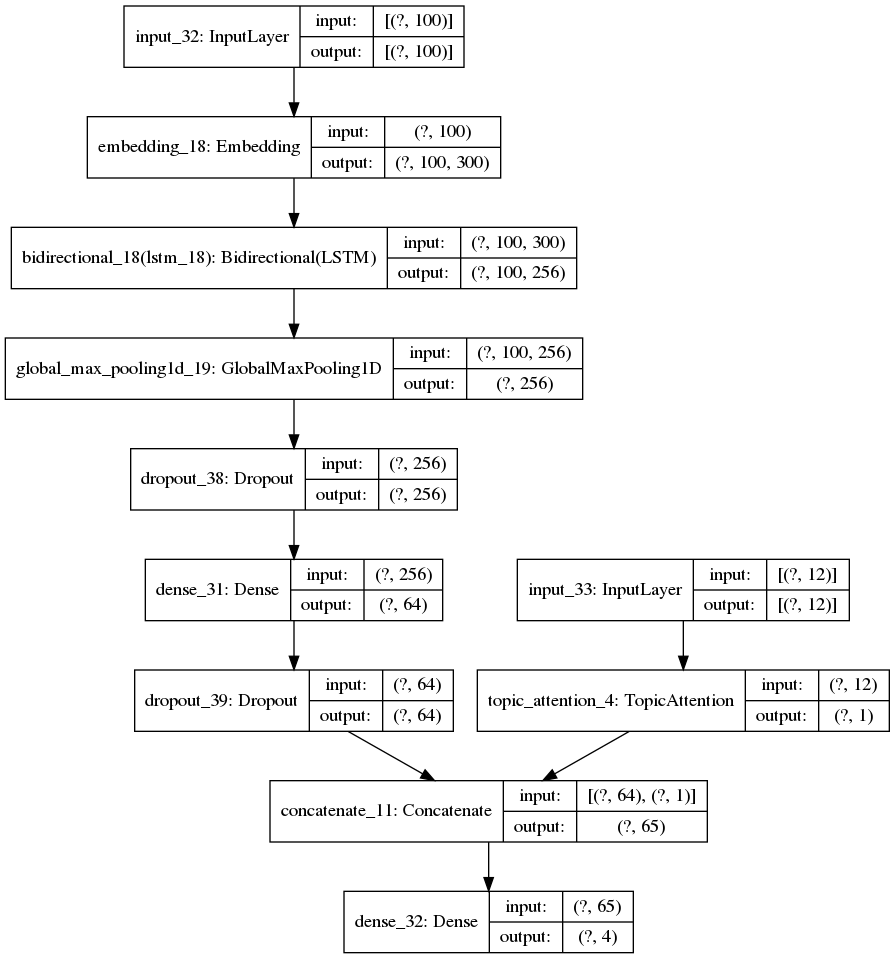

In [59]:
plot_model(classifier, show_shapes=True)

In [60]:
history2 = classifier.fit([x_train_padded, X_train_LDA], 
                          y_train, 
                          epochs=8,
                          batch_size=128,
                          verbose=1,
                          validation_data=([x_val_padded, X_val_LDA], y_val))

Epoch 1/8
329/329 [==============================] - 258s 785ms/step - loss: 0.5183 - acc: 0.8105 - val_loss: 0.3900 - val_acc: 0.8616
Epoch 2/8
329/329 [==============================] - 249s 758ms/step - loss: 0.3592 - acc: 0.8708 - val_loss: 0.3628 - val_acc: 0.8656
Epoch 3/8
329/329 [==============================] - 209s 636ms/step - loss: 0.3186 - acc: 0.8863 - val_loss: 0.3337 - val_acc: 0.8778
Epoch 4/8
329/329 [==============================] - 276s 838ms/step - loss: 0.2802 - acc: 0.8999 - val_loss: 0.3289 - val_acc: 0.8807
Epoch 5/8
329/329 [==============================] - 259s 787ms/step - loss: 0.2485 - acc: 0.9129 - val_loss: 0.3362 - val_acc: 0.8823
Epoch 6/8
329/329 [==============================] - 271s 825ms/step - loss: 0.2183 - acc: 0.9223 - val_loss: 0.3500 - val_acc: 0.8791
Epoch 7/8
329/329 [==============================] - 241s 732ms/step - loss: 0.1957 - acc: 0.9314 - val_loss: 0.3314 - val_acc: 0.8889
Epoch 8/8
329/329 [==============================] - 18

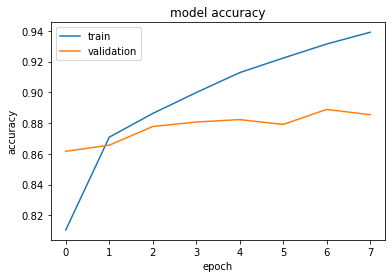

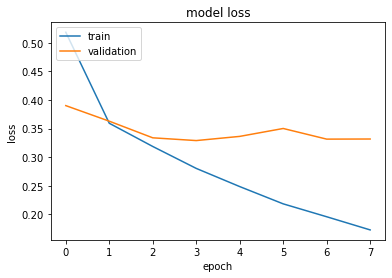

In [61]:
plot_curves(history2)

In [62]:
results2 = np.argmax(classifier.predict([x_val_padded, X_val_LDA]), axis=-1)
acc, precision, recall, f1 = classification_report(y_val, results2)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.885978835978836

Precision:  [0.88502674 0.8790932  0.88789238 0.89632829]
Average Precision:  0.8870851518446182

Recall:  [0.78809524 0.92757475 0.89491525 0.8556701 ]
Average Recall:  0.8665638365639686

F1-Score:  [0.83375315 0.90268348 0.89138998 0.87552743]
Average F1-Score:  0.8758385091789274


In [63]:
save_model(classifier, "multi-channel-BiLSTM-CNN/BiLSTM-LDA-Attention-f1-8758")

Confusion matrix, without normalization


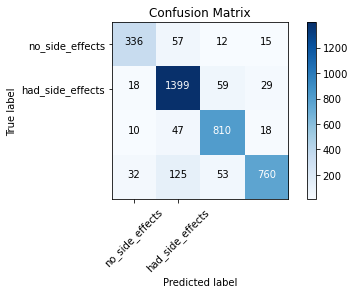

In [26]:
plot_confusion_matrix(y_val, 
                      results2, 
                      classes=['no_side_effects','had_side_effects'], 
                      title='Confusion Matrix',
                      normalize=False)